# Assignment 4. Deep Learning

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For questions 1 refer to @alino_9 on Telegram. For questions 2-4 refer to @alregamo on Telegram.*

### Description  
This homework consists of four questions, each aimed at one category in the world of Deep Learning.   
1. Getting familiarized with sentiment analysis (A subject also covered in the course project).
   
2. Multi-layer perceptron (MLP).
   
3. Convolutional Neural Networks (CNN).
   
4. Variational Autoencoders (VAE).

### Information  
Complete the information box below.

In [1]:
full_name = 'Danial Ataie'
student_id = '99100455'

### Note
The questions are not necessarily in order of difficulty. You are obligated to answer **3 out of 4** questions. The fourth question is optional and is considered as bonus.

## 4 Variation Autoencoder (VAE)

In this [link](https://lilianweng.github.io/posts/2018-08-12-vae/), you can find out more about autoencoders in general and a good explanation about variational autoencoders as well, known as VAEs.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(42)

The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing various image processing and machine learning models. It contains 60,000 training images and 10,000 testing images of size (28, 28) and their corresponding labels from 0 to 9.

In [3]:
# Load the MNIST dataset
dataset = datasets.MNIST('data', train=True, download=True,
                      transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 125207303.74it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56368401.03it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43775897.54it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12933149.20it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### 4.1 Data Visualization

Show 3 random samples from the dataset.

*Hint: you can use "cv2" library for reading images but any other method is acceptable.*

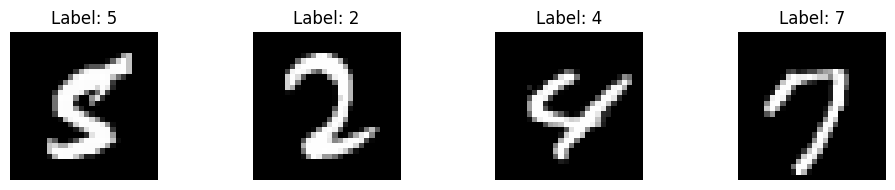

In [4]:
import matplotlib.pyplot as plt
import random

random_samples = random.sample(range(len(dataset)), 4)

# Display three random samples
plt.figure(figsize=(10, 2))
for i, idx in enumerate(random_samples, 1):
    image, label = dataset[idx]
    plt.subplot(1, 4, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

This code defines a VAE class for a variational autoencoder (VAE) model, a generative model with an encoder-decoder based structure. The encoder compresses an input to a latent vector, which is drawn from a distribution learned by the encoder outputs. The decoder reconstructs the input from the latent vector, and the model optimizes the reconstruction quality and the difference between the latent distribution and a prior distribution. A VAE class usually specifies the encoder and decoder networks, the sampling layer, and the loss function.

### 4.2 Complete the following class to define the VAE structure.

In [5]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, latent_size * 2)  # Two outputs for mean and log-variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(),
            nn.Linear(256, input_size),
            nn.Sigmoid()  # Use Sigmoid for binary data, remove for continuous data
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # instead of the encode function, we just put this line here
        mu, logvar = torch.chunk(x, 2, dim=1)

        # Reparameterization
        z = self.reparameterize(mu, logvar)

        # Decoder
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

### 4.3 Define the Loss Function
Compute the binary cross entropy between the reconstructed data and the original data.

Also, you need to compute the KL divergence between the distribution of the latent space and a standard normal distribution.

The total loss would be the sum of these two losses.

In [7]:
def loss_function(recon_x, x, mu, logvar):
    '''
    Compute the binary cross entropy between the reconstructed data and the original data
    Compute the KL divergence between the Gaussian distribution of the latent space and a standard normal distribution
    '''
    BCE_loss = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE_loss + KLD_loss

### 4.4 Training the Model

Here we have provided a function which trains the model using the specified input arguments. (Make sure to understand the code!)

In [12]:
def train(model, optimizer, train_loader, epochs, device):
    model.train()
    train_loss = 0
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1, 784).to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [13]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 784
latent_size = 20
model = VAE(input_size, latent_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
train(model, optimizer, train_loader, epochs, device)

====> Epoch: 9 Average loss: 1145.9960


### 4.5 Generative Model
Now that you have trained your model, you can generate new images by sampling from the latent space and decoding them as below: (make sure to understand how the code works!)

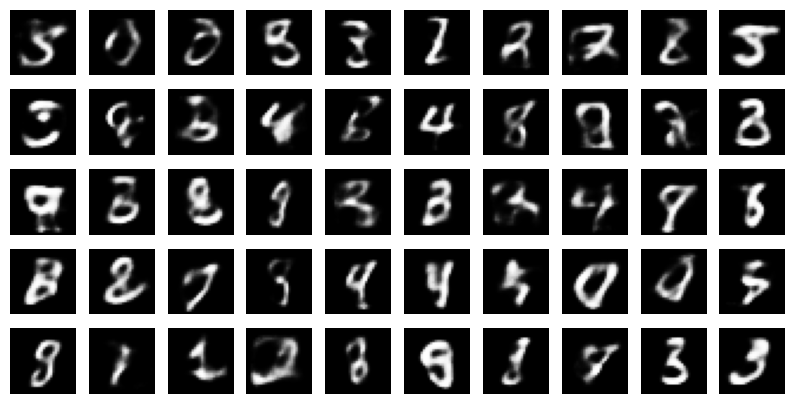

In [15]:
with torch.no_grad():
    z = torch.randn(batch_size, 20).to(device)
    sample = model.decoder(z).cpu()

    # Plot the generated images
    fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(10,5))
    for i in range(5):
        for j in range(10):
            ax[i][j].imshow(sample[i*10+j].reshape(28, 28), cmap='gray')
            ax[i][j].axis('off')
    plt.show()